In [1]:
import glob
import io
import librosa
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import IPython.display as ipd
import seaborn as sns 
import soundfile as sf
import zipfile
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [2]:
output_path = '/Users/thomas/spé-IA/spe_ia_clics_odontocetes/.results/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Set the path to the downloaded data
download_path = Path.cwd() / ".dataset"

# Read labels file
labels_file = download_path / "Y_train_ofTdMHi.csv"
df = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df["relative_path"] = str(download_path) + "/X_train/" + df["id"]

# Drop id column (replaced it with relative_path)
df.drop(columns=["id"], inplace=True)

df.rename(columns={"pos_label": "label"}, inplace=True)

# invert relative_path and label columns positions
df = df[["relative_path", "label"]]
display(ipd.Markdown(f"### There are **_{len(df)}_** audio files in the dataset."))

table = f"""
Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | {df['label'].value_counts()[0]} |
| 1       | {df['label'].value_counts()[1]} |"""
display(ipd.Markdown(table))
df.head()

### There are **_23168_** audio files in the dataset.


Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | 13718 |
| 1       | 9450 |

,relative_path,label
0,/Users/thomas/spé-IA/spe_ia_clics_odontocetes/...,0.0
1,/Users/thomas/spé-IA/spe_ia_clics_odontocetes/...,1.0
2,/Users/thomas/spé-IA/spe_ia_clics_odontocetes/...,1.0
3,/Users/thomas/spé-IA/spe_ia_clics_odontocetes/...,1.0
4,/Users/thomas/spé-IA/spe_ia_clics_odontocetes/...,1.0


### Creating spectrogram images from .wav audio files

In [3]:
def get_images(samples, sr, output_path):
    n_fft = 2048
    hop_length = 512
    n_mels=90
    S = librosa.feature.melspectrogram(y=samples,
                                       sr=sr,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmax=100000)
    S_db = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(2,2))
    librosa.display.specshow(S_db,
                             x_axis='time',
                             y_axis='linear',
                             sr=sr,
                             hop_length=hop_length, 
                             )
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, format='png' , bbox_inches='tight', pad_inches=0)
    plt.close()

KeyboardInterrupt: 

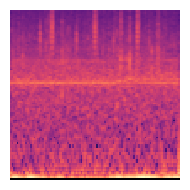

In [4]:
input_directory = Path.cwd() / ".dataset/X_train"
output_directory = "./spectogram_images"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)


for filename in os.listdir(input_directory):
    if filename.endswith(".wav"):  # Check the file extension
        file_path = os.path.join(input_directory, filename)
        output_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}.png")
        
        audio_data, sr = librosa.load(file_path, sr=None)
        get_images(audio_data, sr, output_path)

### Check data distribution

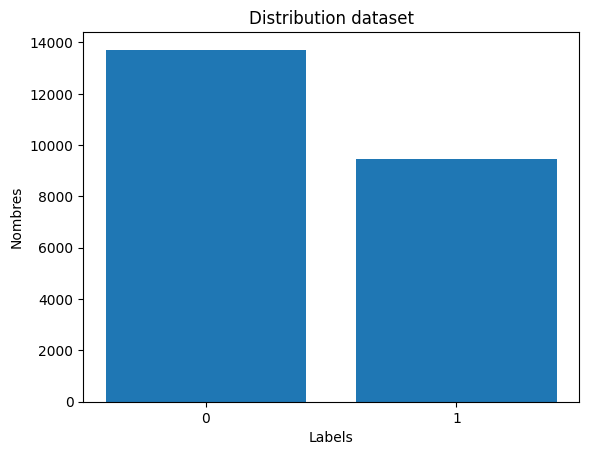

In [5]:
class_counts = df['label'].value_counts()

# Assuming there are only two classes
class_names = ['0', '1']

plt.bar(class_names, [class_counts[0], class_counts[1]])
plt.xlabel('Labels')
plt.ylabel('Nombres')
plt.title('Distribution dataset')
plt.show()

##### mouais ça peut aller ==> pas d'image augmentation pour le moment

In [6]:
NUM_IMAGES = len(os.listdir(Path.cwd() / 'spectogram_images'))
print('Dataset: {} total images'.format(NUM_IMAGES))

Dataset: 23168 total images


In [7]:
train_size = int(0.8 * NUM_IMAGES)
val_size = int(0.2 * NUM_IMAGES)

In [8]:
print(train_size)

18534


In [8]:
# Defining binary focal loss function
def binary_focal_loss(gamma = 2., alpha = .25):
    def tf_binary_focal_loss_fixed(y_true, y_pred):
         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
         epsilon = K.epsilon()
         pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
         pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return tf_binary_focal_loss_fixed

In [10]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.85):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [11]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

In [14]:
pretrained_model = efn.EfficientNetB2(
    weights='imagenet',
    include_top=False ,
    input_shape=[*[255,255], 3]
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

31936256/31936256 [==============================] - 15s 0us/step


In [15]:
model.compile(
    optimizer="adam",
    loss=binary_focal_loss(), 
    metrics=['binary_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functiona  (None, 8, 8, 1408)        7768562   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 40)                56360     
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7824963 (29.85 MB)
Trainable params: 56401 (220.32 KB)
Non-trainable params: 7768562 (29.63 MB)
_________________________________________________________________


In [ ]:
# Training epochs definition 
steps_per_epoch = train_size // BATCH_SIZE

# Fitting the model 
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS[0],
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback,early_stopping]
    )